## Loading & Prepping Data

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


2024-04-13 13:01:37.088849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 13:01:37.233006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-13 13:01:37.233031: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-13 13:01:37.264895: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 13:01:37.993623: W tensorflow/stream_executor/pla

In [ ]:
#data from https://www.kaggle.com/datasets/datamunge/sign-language-mnist/data

asl_train =  pd.read_csv("sign_mnist_train.csv", low_memory = False)
asl_test =  pd.read_csv("sign_mnist_test.csv", low_memory = False)

In [ ]:
X_train = asl_train.iloc[:,1:]
Y_train = asl_train["label"]
X_test = asl_test.iloc[:,1:]
Y_test = asl_test["label"]
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

X_train.shape: (27455, 784)
Y_train.shape: (27455,)
X_test.shape: (7172, 784)
Y_test.shape: (7172,)


In [ ]:
#reshaping data so it can be fed into a CNN. convert to numpy array first to reshape.abs
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (27455, 28, 28, 1)
X_test.shape: (7172, 28, 28, 1)


In [ ]:
# Pixel values range from 0 to 255. To normalize the data, divide all values by 255.
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
#mapping numerical labels to the cooresponding alphabet label
alphabet = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
    6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
    12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z'
}

In [ ]:
alphabet_filtered= [v for k, v in alphabet.items() if v not in ['J','Z']]

## Data Augmentation

In [ ]:
def data_preprocessing(X, y):
    '''Apply transformations and augmentations to data    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
# image augmentation on training data

    # adjust brightness
    X_augm = tf.image.random_brightness(X, 1, seed=None)

    # adjust contrast
    X_augm = tf.image.random_contrast(X, 0.1, 10)

    # random flip
    X_augm = tf.image.random_flip_left_right(X, 1234).numpy()

    # concatenate original X and augmented X_aug data
    X = tf.concat([X, X_augm], axis=0)

    # concatenate y_train (note the label is preserved)
    y_augm = Y_train
    y = tf.concat([y, y_augm],axis=0)

    # shuffle X and y, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
    X = tf.gather(X, shuffle).numpy() 
    y = tf.gather(y, shuffle).numpy()
        
        
    return X, y


X_train, Y_train = data_preprocessing(X_train, Y_train)

2024-04-13 13:01:44.666237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-13 13:01:44.667154: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-13 13:01:44.667179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-7d60a64c-4847-45b1-b561-a742ea0c1506): /proc/driver/nvidia/version does not exist
2024-04-13 13:01:44.674919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 13:01:47.719005: W tensorflow/core/framework/cpu_allocator_impl.c

## Models

### Multiclass Logistic Regression

In [ ]:
mlr = keras.Sequential()
mlr.add(keras.layers.Flatten())
mlr.add(keras.layers.Dense(
    units= 25,
    activation= 'softmax'
))

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

mlr.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

mlr_history = mlr.fit(
    x = X_train,
    y = Y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1)

mlr_history = pd.DataFrame(mlr_history.history)

mlr_test_predictions = np.argmax(mlr.predict(X_test), axis=-1)
print(mlr_test_predictions)

display(mlr_history)

mlr_accuracy = accuracy_score(Y_test, mlr_test_predictions)
print("Accuracy:", mlr_accuracy)

Epoch 1/5
773/773 [==============================] - 3s 3ms/step - loss: 2.9470 - accuracy: 0.1731 - val_loss: 2.7197 - val_accuracy: 0.2424
Epoch 2/5
773/773 [==============================] - 2s 3ms/step - loss: 2.5507 - accuracy: 0.3603 - val_loss: 2.4406 - val_accuracy: 0.3562
Epoch 3/5
773/773 [==============================] - 2s 3ms/step - loss: 2.3173 - accuracy: 0.4330 - val_loss: 2.2552 - val_accuracy: 0.4507
Epoch 4/5
773/773 [==============================] - 2s 3ms/step - loss: 2.1552 - accuracy: 0.4730 - val_loss: 2.1227 - val_accuracy: 0.4305
Epoch 5/5
225/225 [==============================] - 0s 1ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,2.946983,0.173051,2.719742,0.242397
1,2.550703,0.360307,2.440551,0.356219
2,2.317316,0.432971,2.255244,0.450738
3,2.155165,0.472996,2.122724,0.430523
4,2.033287,0.500637,2.008380,0.497359


Accuracy: 0.506553262688232


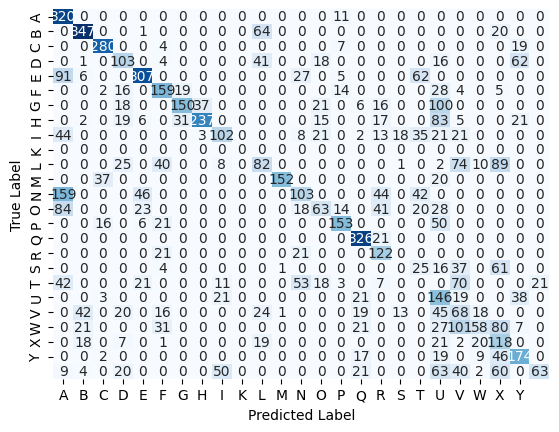

In [ ]:
mlr_confusion_matrix = tf.math.confusion_matrix(Y_test, mlr_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(mlr_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

cnn.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))

cnn.add(Dropout(0.25))

cnn.add(Conv2D(
    filters = 32, 
    kernel_size = (3,3),
    padding = 'same', 
    name='conv_2',
    activation ='relu'))

cnn.add(MaxPool2D(
    pool_size=(2,2),
    name = 'pool_2'))

cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(200, activation = "relu"))

cnn.add(Dropout(0.5))

cnn.add(Dense(25, activation = "softmax"))

In [ ]:
cnn.build(input_shape= X_train.shape)

cnn.compile(optimizer=tf.keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

cnn_history = cnn.fit(x = X_train, y = Y_train, epochs= 5, validation_split=0.1)

Epoch 1/5
1545/1545 [==============================] - 79s 51ms/step - loss: 1.1988 - accuracy: 0.6155 - val_loss: 0.2262 - val_accuracy: 0.9472
Epoch 2/5
1545/1545 [==============================] - 78s 51ms/step - loss: 0.3894 - accuracy: 0.8668 - val_loss: 0.0866 - val_accuracy: 0.9823
Epoch 3/5
1545/1545 [==============================] - 77s 50ms/step - loss: 0.2443 - accuracy: 0.9161 - val_loss: 0.0308 - val_accuracy: 0.9969
Epoch 4/5
1545/1545 [==============================] - 77s 50ms/step - loss: 0.1820 - accuracy: 0.9382 - val_loss: 0.0134 - val_accuracy: 0.9982
Epoch 5/5
1545/1545 [==============================] - 76s 49ms/step - loss: 0.1426 - accuracy: 0.9509 - val_loss: 0.0102 - val_accuracy: 0.9993


In [ ]:
from sklearn.metrics import accuracy_score

cnn_history_df = pd.DataFrame(cnn_history.history)

cnn_test_predictions = np.argmax(cnn.predict(X_test), axis=-1)
print(cnn_test_predictions)

display(cnn_history_df)

cnn_accuracy = accuracy_score(Y_test, cnn_test_predictions)
print("Accuracy:", cnn_accuracy)

225/225 [==============================] - 3s 13ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,1.198839,0.615492,0.226218,0.947186
1,0.389396,0.866792,0.086630,0.982335
2,0.244277,0.916146,0.030832,0.996904
3,0.182046,0.938182,0.013416,0.998179
4,0.142595,0.950930,0.010217,0.999272


Accuracy: 0.939765755716676


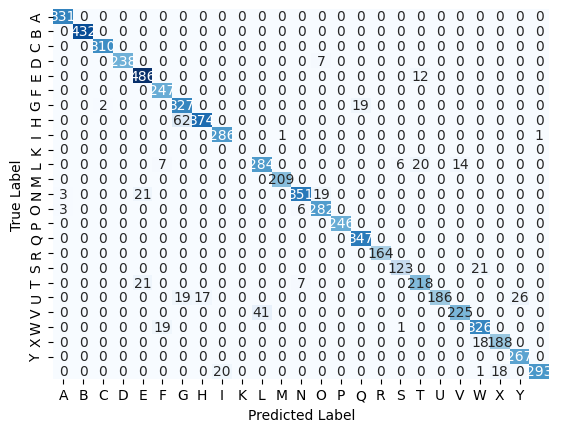

In [ ]:
cnn_confusion_matrix = tf.math.confusion_matrix(Y_test, cnn_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(cnn_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### LeNet-5

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy

X_train_pad = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test_pad = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

lenet = Sequential(name="LeNet-5")

lenet.add(Conv2D(6,(5,5),strides=(1,1), activation='tanh',input_shape=(32,32,1), name='C1')) # C1
lenet.add(AveragePooling2D(name='S2'))# S2
lenet.add(Conv2D(16,(5,5),strides=(1,1),activation='tanh',name='C3')) #C3
lenet.add(AveragePooling2D(name='S4')) #S4
lenet.add(Flatten())
lenet.add(Dense(120,activation='tanh',name='FC5')) #FC5
lenet.add(Dense(84,activation='tanh',name='FC6')) #FC6
lenet.add(Dense(25,activation='softmax',name='Output')) #FC7

lenet.compile(optimizer='adam',loss= keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

lenet_history = lenet.fit(X_train_pad, Y_train, validation_split=0.1, epochs=5)

Epoch 1/5
1545/1545 [==============================] - 52s 33ms/step - loss: 1.0030 - accuracy: 0.7172 - val_loss: 0.2973 - val_accuracy: 0.9399
Epoch 2/5
1545/1545 [==============================] - 54s 35ms/step - loss: 0.1196 - accuracy: 0.9835 - val_loss: 0.0436 - val_accuracy: 0.9969
Epoch 3/5
1545/1545 [==============================] - 52s 33ms/step - loss: 0.0236 - accuracy: 0.9985 - val_loss: 0.0108 - val_accuracy: 0.9998
Epoch 4/5
1545/1545 [==============================] - 52s 34ms/step - loss: 0.0055 - accuracy: 0.9999 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 5/5
1545/1545 [==============================] - 52s 34ms/step - loss: 0.0269 - accuracy: 0.9928 - val_loss: 0.0029 - val_accuracy: 1.0000


In [ ]:
lenet_history_df = pd.DataFrame(lenet_history.history)

lenet_test_predictions = np.argmax(lenet.predict(X_test_pad), axis=-1)
print(lenet_test_predictions)

display(lenet_history_df)

lenet_accuracy = accuracy_score(Y_test, lenet_test_predictions)
print("Accuracy:", lenet_accuracy)

225/225 [==============================] - 3s 12ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,1.002983,0.717174,0.297297,0.939902
1,0.119573,0.983529,0.043626,0.996904
2,0.023562,0.998503,0.010841,0.999818
3,0.005496,0.999879,0.003149,1.000000
4,0.026886,0.992837,0.002884,1.000000


Accuracy: 0.8098159509202454


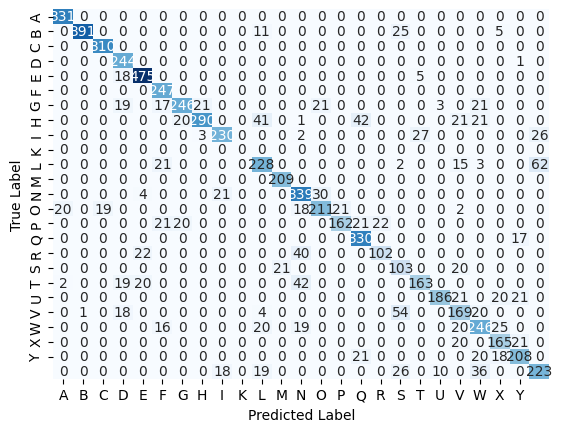

In [ ]:
lenet_confusion_matrix = tf.math.confusion_matrix(Y_test, lenet_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(lenet_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if strides != (1, 1) or x.shape[-1] != filters:
        x = layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
    
    out = layers.Add()([x, y])
    out = layers.Activation(activation)(out)
    
    return out

def ResNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    
    x = residual_block(x, filters=128, strides=(2, 2))
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    
    x = residual_block(x, filters=256, strides=(2, 2))
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    return model

input_shape = (28, 28, 1)
num_classes = 25

model = ResNet(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

resnet_history = model.fit(X_train, Y_train, epochs=5, validation_split=0.1, batch_size=32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalization[0][0]']

In [ ]:
resnet_history_df = pd.DataFrame(resnet_history.history)

resnet_test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(resnet_test_predictions)

display(resnet_history_df)

resnet_accuracy = accuracy_score(Y_test, resnet_test_predictions)
print("Accuracy:", resnet_accuracy)

225/225 [==============================] - 17s 76ms/step
[ 6  5 10 ... 14  4 14]


,loss,accuracy,val_loss,val_accuracy
0,0.309327,0.899694,0.119407,0.960117
1,0.043442,0.986726,0.118497,0.960299
2,0.034910,0.989984,0.055421,0.982153
3,0.025707,0.992189,0.008980,0.997268
4,0.019172,0.994779,0.071978,0.979239


Accuracy: 0.9148075850529839


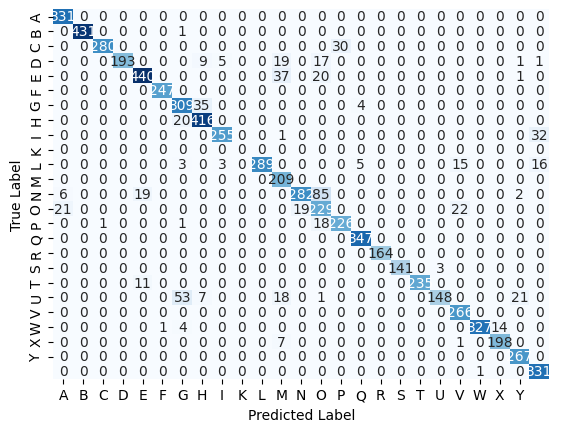

In [ ]:
resnet_confusion_matrix = tf.math.confusion_matrix(Y_test, resnet_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(resnet_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### EfficientNet

In [ ]:
from keras.applications import EfficientNetB0

effnet = EfficientNetB0(
    include_top = True,
    weights = None,
    classes = 25,
    input_shape = (32, 32, 1),
)

effnet.compile(optimizer = "adam", loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

effnet.summary()

effnet_history = effnet.fit(X_train_pad,Y_train, validation_split=0.1, epochs=5, batch_size = 64)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 32, 32, 1)    0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 32, 32, 1)   3           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 1)    0           ['normalization_1[0]

In [ ]:
effnet_history_df = pd.DataFrame(effnet_history.history)

effnet_test_predictions = np.argmax(effnet.predict(X_test_pad), axis=-1)
print(effnet_test_predictions)

display(effnet_history_df)

effnet_accuracy = accuracy_score(Y_test, effnet_test_predictions)
print("Accuracy:", effnet_accuracy)

225/225 [==============================] - 20s 83ms/step
[ 6  5 10 ...  2  4  2]


,loss,accuracy,val_loss,val_accuracy
0,2.381538,0.385398,1.829865,0.417046
1,0.777317,0.804083,1.136731,0.824076
2,0.596957,0.859305,0.528075,0.865780
3,0.522055,0.884660,0.173806,0.963577
4,0.258512,0.943949,0.060143,0.987798


Accuracy: 0.7943390964863357


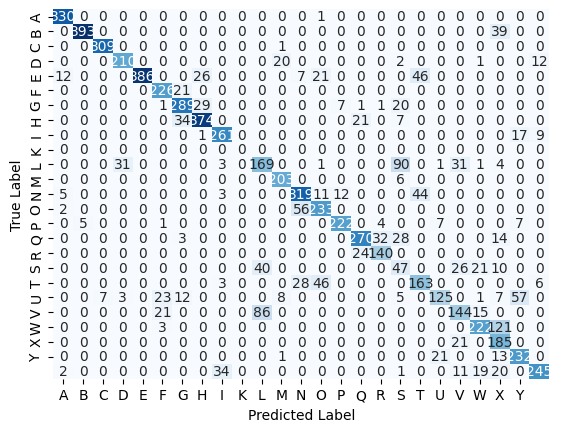

In [ ]:
effnet_confusion_matrix = tf.math.confusion_matrix(Y_test, effnet_test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(effnet_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels = alphabet_filtered, yticklabels = alphabet_filtered, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7d60a64c-4847-45b1-b561-a742ea0c1506' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>